In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from scipy import stats
# import gffutils

%matplotlib inline

#### Pandas Viewing Settings

In [2]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

### Set matplotlib text export settings for Adobe Illustrator

In [3]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

## Define Directories

In [4]:
PB_Vs_Illumina_DataAnalysis_Dir = "../../../210112_PBvsI_VCeval_AnalysisDir_V7_36CI"

FalsePositive_Analysis_V2_Dir = PB_Vs_Illumina_DataAnalysis_Dir + "/210126_FalsePositivesAnalysis_V4"  

PBvIll_EBR_Dir = PB_Vs_Illumina_DataAnalysis_Dir + "/210112_EBR_H37rv_36CI_MM2vsPilon_V7"         



## Parse Assembly and Sequence analysis results Sample Info

In [5]:
Repo_DataDir = "../../Data"

PMP_SM_ResultsSummary_Dir_210108 = Repo_DataDir + "/210108_PMP_SM_50CI_V7_ResultsSummary"

PMP_36CI_CicularOnly_F2Filtered_AtLeast40XIllDepth_AssemblySummary_TSV_PATH = PMP_SM_ResultsSummary_Dir_210108 + "/210108_PMP_36CI_CircularOnly_F2Filtered_AtLeast40XMeanDepthIllumina_AssemblySummary_V7.tsv"       

PMP_36CI_CicularOnly_F2Filtered_AtLeast40XDepth_AssemblySummary = pd.read_csv(PMP_36CI_CicularOnly_F2Filtered_AtLeast40XIllDepth_AssemblySummary_TSV_PATH, sep = "\t")

PMP_36CI_AnalysisSet_AssemblySummary = PMP_36CI_CicularOnly_F2Filtered_AtLeast40XDepth_AssemblySummary


SampleIDs_36CI_SOI = list( PMP_36CI_AnalysisSet_AssemblySummary["SampleID"].values )


print(','.join(SampleIDs_36CI_SOI) )

# Make sample to metadata mapping dicts

ID_To_IlluminaAvrgCov_Dict = dict(PMP_36CI_AnalysisSet_AssemblySummary[['SampleID', 'IlluminaWGSToH37rv_AvrgCov']].values)                     
ID_To_Lineage_Dict = dict(PMP_36CI_AnalysisSet_AssemblySummary[['SampleID', 'PrimaryLineage_PB']].values)
ID_To_Dataset_Dict = dict(PMP_36CI_AnalysisSet_AssemblySummary[['SampleID', 'Dataset_Tag']].values)

M0011368_9,M0014888_3,M0016395_7,M0010874_7,01_R1430,02_R0894,02_R1708,02_R1896,M0016737_0,M0017522_5,01_R1134,M0003941_3,02_R1179,N1176,N0072,N0153,N0145,N0155,N0004,N1274,N0054,N1272,N0091,N1202,N1177,RW-TB008,DNA028,DNA075,DNA091,DNA044,DNA020,AZE_02_042,DNA019_Rose,DNA120,DNA188,DNA086


## 1) Read back in EBR and Pmappability H37rv gene level analysis

In [6]:
#Repo_DataDir = "../../Data"


FeatureLevelAnalysis_Dir_O2 = PBvIll_EBR_Dir + "/210113_H37Rv_FeatureLevelAnalysis_EBR_Pmap" 


H37Rv_FeatureLevelAnalysis_EBR_Pmap_TSV_O2_Repo = f"{FeatureLevelAnalysis_Dir_O2}/H37Rv_FeatureLevelAnalysis.EBR_And_Pmap.tsv"
H37Rv_GeneLevelAnalysis_EBR_Pmap_TSV_O2_Repo = f"{FeatureLevelAnalysis_Dir_O2}/H37Rv_FeatureLevelAnalysis.EBR_And_Pmap.Genes.tsv"
H37Rv_IntergenicLevelAnalysis_EBR_Pmap_TSV_O2_Repo = f"{FeatureLevelAnalysis_Dir_O2}/H37Rv_FeatureLevelAnalysis.EBR_And_Pmap.IntergenicRegions.tsv"

FLA_DF = pd.read_csv(H37Rv_FeatureLevelAnalysis_EBR_Pmap_TSV_O2_Repo, sep = "\t",)

GLA_DF = pd.read_csv(H37Rv_GeneLevelAnalysis_EBR_Pmap_TSV_O2_Repo, sep = "\t",)

# Parsing in MERGED False Positives SNSs

In [7]:
All_FPs_SNPs_FiltMQ30_VCF_PATH = f"{FalsePositive_Analysis_V2_Dir}/PMP_36CI.SNPs.All.FPs.FiltMQ30.vcf"
All_FPs_SNPs_VCF_PATH = f"{FalsePositive_Analysis_V2_Dir}/PMP_36CI.SNPs.All.FPs.vcf"


H37rv_AllRegions_AnnoBy_All_FPs_PATH = f"{FalsePositive_Analysis_V2_Dir}/200901_Mtb_H37rv_AllRegions_Info.SNPs.All.FPs.bed" 
H37rv_AllRegions_AnnoBy_All_FPs_FiltMQ30_PATH = f"{FalsePositive_Analysis_V2_Dir}/200901_Mtb_H37rv_AllRegions_Info.SNPs.FPs.FiltMQ30.bed" 



In [8]:
AllRegions_AnnoByFPs_DF = pd.read_csv(H37rv_AllRegions_AnnoBy_All_FPs_PATH, sep="\t", header=None)

AllRegions_AnnoByFPs_DF.columns = ['Chrom', 'Start', 'End',
                                    'Strand', 'H37rv_GeneID', 'Symbol',
                                    'ExcludedGroup_Category', 'PEandPPE_Subfamily',
                                    'Functional_Category', "FP_Count"] 
                                   
AllRegions_AnnoByFPs_DF = AllRegions_AnnoByFPs_DF.sort_values("Start")
AllRegions_AnnoByFPs_DF["Length"] = AllRegions_AnnoByFPs_DF["End"] - AllRegions_AnnoByFPs_DF["Start"]

# Select for the top 30 regions based on the total # of FPs detected across all 36 isolates
Regions_Top30SourcesOfFPs_DF = AllRegions_AnnoByFPs_DF.sort_values("FP_Count", ascending=False).head(30)

AllRegions_AnnoByFPs_DF.head()

,Chrom,Start,End,Strand,H37rv_GeneID,Symbol,ExcludedGroup_Category,PEandPPE_Subfamily,Functional_Category,FP_Count,Length
271,NC_000962.3,0,1524,+,Rv0001,dnaA,NotExcluded,None,information pathways,0,1524
272,NC_000962.3,1524,2051,NaN,IntergenicRegion_1_Rv0001-Rv0002,NaN,Intergenic,NaN,Intergenic,0,527
273,NC_000962.3,2051,3260,+,Rv0002,dnaN,NotExcluded,None,information pathways,0,1209
274,NC_000962.3,3260,3279,NaN,IntergenicRegion_2_Rv0002-Rv0003,NaN,Intergenic,NaN,Intergenic,0,19
275,NC_000962.3,3279,4437,+,Rv0003,recF,NotExcluded,None,information pathways,0,1158


In [9]:
#AllRegions_AnnoByFPs_DF.sort_values("FP_Count", ascending=False).head(20)["FP_Count"].sum() / AllRegions_AnnoByFPs_DF["FP_Count"].sum()   


In [10]:
#AllRegions_AnnoByFPs_DF.sort_values("FP_Count", ascending=False).head(30)["FP_Count"].sum() / AllRegions_AnnoByFPs_DF["FP_Count"].sum()   


In [11]:
AllRegions_AnnoByFPs_FiltMQ30_DF = pd.read_csv(H37rv_AllRegions_AnnoBy_All_FPs_FiltMQ30_PATH, sep="\t", header=None)

AllRegions_AnnoByFPs_FiltMQ30_DF.columns = ['Chrom', 'Start', 'End',
                                    'Strand', 'H37rv_GeneID', 'Symbol',
                                    'ExcludedGroup_Category', 'PEandPPE_Subfamily',
                                    'Functional_Category', "FP_Count"] 
                                   
AllRegions_AnnoByFPs_FiltMQ30_DF = AllRegions_AnnoByFPs_FiltMQ30_DF.sort_values("Start")
AllRegions_AnnoByFPs_FiltMQ30_DF["Length"] = AllRegions_AnnoByFPs_FiltMQ30_DF["End"] - AllRegions_AnnoByFPs_FiltMQ30_DF["Start"]

# Select for the top 30 regions based on the total # of FPs detected across all 36 isolates
Regions_Top30SourcesOfFPs_FiltMQ30_DF = AllRegions_AnnoByFPs_FiltMQ30_DF.sort_values("FP_Count", ascending=False).head(30)


AllRegions_AnnoByFPs_FiltMQ30_DF.head()

,Chrom,Start,End,Strand,H37rv_GeneID,Symbol,ExcludedGroup_Category,PEandPPE_Subfamily,Functional_Category,FP_Count,Length
271,NC_000962.3,0,1524,+,Rv0001,dnaA,NotExcluded,None,information pathways,0,1524
272,NC_000962.3,1524,2051,NaN,IntergenicRegion_1_Rv0001-Rv0002,NaN,Intergenic,NaN,Intergenic,0,527
273,NC_000962.3,2051,3260,+,Rv0002,dnaN,NotExcluded,None,information pathways,0,1209
274,NC_000962.3,3260,3279,NaN,IntergenicRegion_2_Rv0002-Rv0003,NaN,Intergenic,NaN,Intergenic,0,19
275,NC_000962.3,3279,4437,+,Rv0003,recF,NotExcluded,None,information pathways,0,1158


In [12]:
AllRegions_AnnoByFPs_DF["FP_Count"].sum()

696

In [13]:
Regions_Top30SourcesOfFPs_DF["FP_Count"].sum()

634

In [14]:
634 / 696

0.9109195402298851

In [15]:
AllRegions_AnnoByFPs_FiltMQ30_DF["FP_Count"].sum()

548

In [16]:
Regions_Top30SourcesOfFPs_FiltMQ30_DF["FP_Count"].sum()

490

In [17]:
490 / 548

0.8941605839416058

In [18]:
AllRegions_AnnoByFPs_FiltMQ30_DF.shape

(7151, 11)

# What proportion of all FPs are in PE-PGRS and PPE-MPTR genes?

In [19]:
AllRegions_AnnoByFPs_FiltMQ30_DF.groupby("PEandPPE_Subfamily").sum()

,Start,End,FP_Count,Length
PEandPPE_Subfamily,,,,
None,8641207844,8644987360,82,3779516
PE_III_,7103727,7104261,0,534
PE_II_,1911086,1911704,0,618
PE_IV_,24328669,24333022,0,4353
PE_I_,8546914,8547550,0,636
PE_V_,22492721,22507010,0,14289
PE_V_PGRS,124414424,124536737,169,122313
PPE_SL-1_nan,4351074,4352181,0,1107
PPE_SL-2_PPE-PPW,16536167,16548764,0,12597


In [20]:
80 + 169

249

In [21]:
249 / 548

0.4543795620437956

In [22]:
AllRegions_AnnoByFPs_FiltMQ30_DF["PEandPPE_Subfamily"].value_counts()

None                        3924
PE_V_PGRS                     60
PPE_SL-4_PPE-SVP              25
PPE_SL-5_PPE-MPTR             20
PE_V_                         15
PE_IV_                        11
PPE_SL-2_PPE-PPW              10
PPE_SL-3_nan                   6
PE_II_                         2
PE_I_                          2
PE_III_                        2
PPE_SL-N.A._Inconclusive       1
PPE_SL-1_nan                   1
Name: PEandPPE_Subfamily, dtype: int64

### Investigate: "What % of genes are responsible for ___% of FPs (MQ >=30)"

In [23]:
Regions_Top30SourcesOfFPs_FiltMQ30_DF["FP_Count"].sum()

490

In [24]:
Regions_Top30SourcesOfFPs_FiltMQ30_DF["FP_Count"].sum() / AllRegions_AnnoByFPs_FiltMQ30_DF["FP_Count"].sum()

0.8941605839416058

In [25]:
AllRegions_AnnoByFPs_FiltMQ30_DF.sort_values("FP_Count", ascending=False).head(30)["FP_Count"].sum() / AllRegions_AnnoByFPs_FiltMQ30_DF["FP_Count"].sum()

0.8941605839416058

### Breakdown of genes and intergenic regions

In [26]:
Regions_Top30SourcesOfFPs_FiltMQ30_DF

,Chrom,Start,End,Strand,H37rv_GeneID,Symbol,ExcludedGroup_Category,PEandPPE_Subfamily,Functional_Category,FP_Count,Length
6286,NC_000962.3,3845970,3847164,NaN,IntergenicRegion_2683_Rv3428c-Rv3429,NaN,Intergenic,NaN,Intergenic,142,1194
2840,NC_000962.3,1636003,1638229,-,Rv1452c,PE_PGRS28,PE/PPEs,PE_V_PGRS,PE/PPE,59,2226
3645,NC_000962.3,2162931,2167311,-,Rv1917c,PPE34,PE/PPEs,PPE_SL-5_PPE-MPTR,PE/PPE,35,4380
138,NC_000962.3,1981613,1984775,-,Rv1753c,PPE24,PE/PPEs,PPE_SL-5_PPE-MPTR,PE/PPE,24,3162
6428,NC_000962.3,3941723,3944963,+,Rv3512,PE_PGRS56,PE/PPEs,PE_V_PGRS,PE/PPE,16,3240
5393,NC_000962.3,3232506,3232870,NaN,IntergenicRegion_2285_Rv2920c-Rv2921c,NaN,Intergenic,NaN,Intergenic,16,364
30,NC_000962.3,3931004,3936710,+,Rv3508,PE_PGRS54,PE/PPEs,PE_V_PGRS,PE/PPE,16,5706
5574,NC_000962.3,3379375,3380452,-,Rv3021c,PPE47,PE/PPEs,None,PE/PPE,14,1077
186,NC_000962.3,2867123,2867786,+,Rv2544,lppB,Coscolla Repetitive Genes,None,cell wall and cell processes,14,663
245,NC_000962.3,3945793,3950263,+,Rv3514,PE_PGRS57,PE/PPEs,PE_V_PGRS,PE/PPE,14,4470


In [27]:
Regions_Top30SourcesOfFPs_FiltMQ30_DF["ExcludedGroup_Category"].value_counts()

PE/PPEs                      17
Intergenic                    7
InsertionSeqs_And_Phages      3
Coscolla Repetitive Genes     2
NotExcluded                   1
Name: ExcludedGroup_Category, dtype: int64

In [28]:
15

15

In [29]:
# 23 genes, 7 intergenic regions

## Length of top 30 High FP Regions

In [30]:
Regions_Top30SourcesOfFPs_FiltMQ30_DF["Length"].sum()

65394

In [31]:
Regions_Top30SourcesOfFPs_FiltMQ30_DF["Length"].sum()/ 4411532 * 100

1.4823421886093087

In [32]:
Regions_Top30SourcesOfFPs_FiltMQ30_DF.head(3)

,Chrom,Start,End,Strand,H37rv_GeneID,Symbol,ExcludedGroup_Category,PEandPPE_Subfamily,Functional_Category,FP_Count,Length
6286,NC_000962.3,3845970,3847164,NaN,IntergenicRegion_2683_Rv3428c-Rv3429,NaN,Intergenic,NaN,Intergenic,142,1194
2840,NC_000962.3,1636003,1638229,-,Rv1452c,PE_PGRS28,PE/PPEs,PE_V_PGRS,PE/PPE,59,2226
3645,NC_000962.3,2162931,2167311,-,Rv1917c,PPE34,PE/PPEs,PPE_SL-5_PPE-MPTR,PE/PPE,35,4380


In [33]:
Regions_Top30SourcesOfFPs_FiltMQ30_DF

,Chrom,Start,End,Strand,H37rv_GeneID,Symbol,ExcludedGroup_Category,PEandPPE_Subfamily,Functional_Category,FP_Count,Length
6286,NC_000962.3,3845970,3847164,NaN,IntergenicRegion_2683_Rv3428c-Rv3429,NaN,Intergenic,NaN,Intergenic,142,1194
2840,NC_000962.3,1636003,1638229,-,Rv1452c,PE_PGRS28,PE/PPEs,PE_V_PGRS,PE/PPE,59,2226
3645,NC_000962.3,2162931,2167311,-,Rv1917c,PPE34,PE/PPEs,PPE_SL-5_PPE-MPTR,PE/PPE,35,4380
138,NC_000962.3,1981613,1984775,-,Rv1753c,PPE24,PE/PPEs,PPE_SL-5_PPE-MPTR,PE/PPE,24,3162
6428,NC_000962.3,3941723,3944963,+,Rv3512,PE_PGRS56,PE/PPEs,PE_V_PGRS,PE/PPE,16,3240
5393,NC_000962.3,3232506,3232870,NaN,IntergenicRegion_2285_Rv2920c-Rv2921c,NaN,Intergenic,NaN,Intergenic,16,364
30,NC_000962.3,3931004,3936710,+,Rv3508,PE_PGRS54,PE/PPEs,PE_V_PGRS,PE/PPE,16,5706
5574,NC_000962.3,3379375,3380452,-,Rv3021c,PPE47,PE/PPEs,None,PE/PPE,14,1077
186,NC_000962.3,2867123,2867786,+,Rv2544,lppB,Coscolla Repetitive Genes,None,cell wall and cell processes,14,663
245,NC_000962.3,3945793,3950263,+,Rv3514,PE_PGRS57,PE/PPEs,PE_V_PGRS,PE/PPE,14,4470


In [34]:
AllRegions_AnnoByFPs_FiltMQ30_DF.sort_values("FP_Count", ascending=False).head(30)

,Chrom,Start,End,Strand,H37rv_GeneID,Symbol,ExcludedGroup_Category,PEandPPE_Subfamily,Functional_Category,FP_Count,Length
6286,NC_000962.3,3845970,3847164,NaN,IntergenicRegion_2683_Rv3428c-Rv3429,NaN,Intergenic,NaN,Intergenic,142,1194
2840,NC_000962.3,1636003,1638229,-,Rv1452c,PE_PGRS28,PE/PPEs,PE_V_PGRS,PE/PPE,59,2226
3645,NC_000962.3,2162931,2167311,-,Rv1917c,PPE34,PE/PPEs,PPE_SL-5_PPE-MPTR,PE/PPE,35,4380
138,NC_000962.3,1981613,1984775,-,Rv1753c,PPE24,PE/PPEs,PPE_SL-5_PPE-MPTR,PE/PPE,24,3162
6428,NC_000962.3,3941723,3944963,+,Rv3512,PE_PGRS56,PE/PPEs,PE_V_PGRS,PE/PPE,16,3240
5393,NC_000962.3,3232506,3232870,NaN,IntergenicRegion_2285_Rv2920c-Rv2921c,NaN,Intergenic,NaN,Intergenic,16,364
30,NC_000962.3,3931004,3936710,+,Rv3508,PE_PGRS54,PE/PPEs,PE_V_PGRS,PE/PPE,16,5706
5574,NC_000962.3,3379375,3380452,-,Rv3021c,PPE47,PE/PPEs,None,PE/PPE,14,1077
186,NC_000962.3,2867123,2867786,+,Rv2544,lppB,Coscolla Repetitive Genes,None,cell wall and cell processes,14,663
245,NC_000962.3,3945793,3950263,+,Rv3514,PE_PGRS57,PE/PPEs,PE_V_PGRS,PE/PPE,14,4470


In [35]:
AllRegions_AnnoByFPs_FiltMQ30_DF["FP_Count"].sum()

548

In [36]:
AllRegions_AnnoByFPs_FiltMQ30_DF.groupby("ExcludedGroup_Category").sum()

,Start,End,FP_Count,Length
ExcludedGroup_Category,,,,
Coscolla Repetitive Genes,168204775,168285322,26,80547
InsertionSeqs_And_Phages,364622673,364731336,20,108663
Intergenic,6731198364,6731584086,217,385722
NotExcluded,8071642055,8075211718,14,3569663
PE/PPEs,375075922,375359266,271,283344


In [37]:
556 - 14 

542

In [38]:
14 / 556 # were 

0.025179856115107913

In [39]:
542 / 556 # were

0.9748201438848921

In [40]:
86 + 169


255

In [41]:
255/556

0.45863309352517984

# Merge Gene-level analysis of EBR w/ the False Positive Level Analysis of genes

In [42]:
GLA_DF.head(2)

,Chrom,Start,End,Strand,H37rv_GeneID,Symbol,Feature,ExcludedGroup_Category,PEandPPE_Subfamily,Product,Functional_Category,Is_Pseudogene,Mean_EBR_36CI,gene_PercentPerfect_EBR_36CI,gene_ProportionWith_NANs_EBR_36CI,gene_GC_Content,Mean_PileupMapScore_K50_E4,Mean_PileupMapScore_K100_E4,Mean_PileupMapScore_K125_E4,Length
0,NC_000962.3,0,1524,+,Rv0001,dnaA,CDS,NotExcluded,None,Chromosomal replication initiator protein DnaA,information pathways,No,0.997430,92.979003,0.0,58.923885,1.0,1.0,1.0,1524
1,NC_000962.3,2051,3260,+,Rv0002,dnaN,CDS,NotExcluded,None,DNA polymerase III (beta chain) DnaN (DNA nucl...,information pathways,No,0.998093,93.134822,0.0,59.966915,1.0,1.0,1.0,1209


In [43]:
AllRegions_AnnoByFPs_FiltMQ30_DF.head(2)

,Chrom,Start,End,Strand,H37rv_GeneID,Symbol,ExcludedGroup_Category,PEandPPE_Subfamily,Functional_Category,FP_Count,Length
271,NC_000962.3,0,1524,+,Rv0001,dnaA,NotExcluded,None,information pathways,0,1524
272,NC_000962.3,1524,2051,NaN,IntergenicRegion_1_Rv0001-Rv0002,NaN,Intergenic,NaN,Intergenic,0,527


In [44]:
CommonCol_MergeOn = ["Start", "End", "H37rv_GeneID", "Symbol", "Functional_Category", "PEandPPE_Subfamily", "ExcludedGroup_Category"]

cols_to_use_From_FP_Df = AllRegions_AnnoByFPs_FiltMQ30_DF.columns.difference(GLA_DF.columns)


GLA_DF_WiFPs = GLA_DF.merge( AllRegions_AnnoByFPs_FiltMQ30_DF, left_on = CommonCol_MergeOn, right_on = CommonCol_MergeOn, how="left")      

In [45]:
GLA_DF_WiFPs.shape

(4079, 24)

In [46]:
GLA_DF_WiFPs.head()

,Chrom_x,Start,End,Strand_x,H37rv_GeneID,Symbol,Feature,ExcludedGroup_Category,PEandPPE_Subfamily,Product,Functional_Category,Is_Pseudogene,Mean_EBR_36CI,gene_PercentPerfect_EBR_36CI,gene_ProportionWith_NANs_EBR_36CI,gene_GC_Content,Mean_PileupMapScore_K50_E4,Mean_PileupMapScore_K100_E4,Mean_PileupMapScore_K125_E4,Length_x,Chrom_y,Strand_y,FP_Count,Length_y
0,NC_000962.3,0,1524,+,Rv0001,dnaA,CDS,NotExcluded,None,Chromosomal replication initiator protein DnaA,information pathways,No,0.997430,92.979003,0.0,58.923885,1.0,1.0,1.0,1524,NC_000962.3,+,0,1524
1,NC_000962.3,2051,3260,+,Rv0002,dnaN,CDS,NotExcluded,None,DNA polymerase III (beta chain) DnaN (DNA nucl...,information pathways,No,0.998093,93.134822,0.0,59.966915,1.0,1.0,1.0,1209,NC_000962.3,+,0,1209
2,NC_000962.3,3279,4437,+,Rv0003,recF,CDS,NotExcluded,None,DNA replication and repair protein RecF (singl...,information pathways,No,1.000000,100.000000,0.0,59.930915,1.0,1.0,1.0,1158,NC_000962.3,+,0,1158
3,NC_000962.3,4433,4997,+,Rv0004,Rv0004,CDS,NotExcluded,None,Conserved hypothetical protein,conserved hypotheticals,No,1.000000,100.000000,0.0,66.134752,1.0,1.0,1.0,564,NC_000962.3,+,0,564
4,NC_000962.3,5239,7267,+,Rv0005,gyrB,CDS,NotExcluded,None,DNA gyrase (subunit B) GyrB (DNA topoisomerase...,information pathways,No,1.000000,100.000000,0.0,60.207101,1.0,1.0,1.0,2028,NC_000962.3,+,0,2028


In [47]:
GLA_DF_WiFPs[ GLA_DF_WiFPs["Symbol"] == "PPE13" ]

,Chrom_x,Start,End,Strand_x,H37rv_GeneID,Symbol,Feature,ExcludedGroup_Category,PEandPPE_Subfamily,Product,Functional_Category,Is_Pseudogene,Mean_EBR_36CI,gene_PercentPerfect_EBR_36CI,gene_ProportionWith_NANs_EBR_36CI,gene_GC_Content,Mean_PileupMapScore_K50_E4,Mean_PileupMapScore_K100_E4,Mean_PileupMapScore_K125_E4,Length_x,Chrom_y,Strand_y,FP_Count,Length_y
916,NC_000962.3,976871,978203,-,Rv0878c,PPE13,CDS,PE/PPEs,PPE_SL-5_PPE-MPTR,PPE family protein PPE13,PE/PPE,No,0.995579,89.78979,0.0,64.414414,0.996246,1.0,1.0,1332,NC_000962.3,-,0,1332


mkdir: cannot create directory ‘./H37rv_GenomeMetrics_Plots_V7/’: File exists


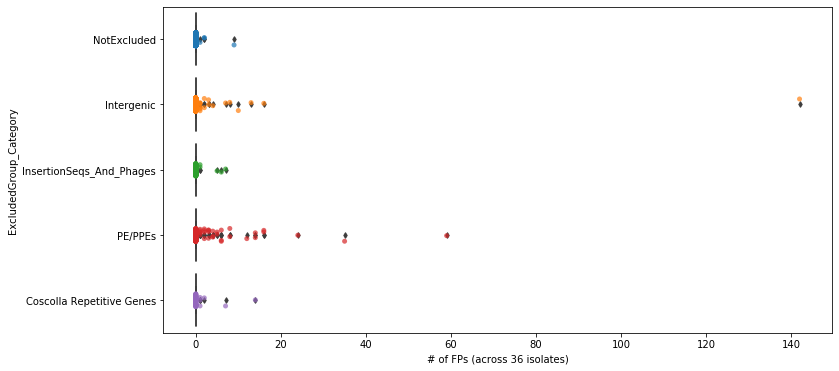

In [48]:
fig, axs = plt.subplots(1, 1, figsize=(12, 6) ) #, sharex=True)

sns.boxplot(y = "ExcludedGroup_Category", x = "FP_Count",
           data = AllRegions_AnnoByFPs_FiltMQ30_DF, 
            whis = 1.5,
            fliersize = 4, ax = axs)

sns.stripplot(y="ExcludedGroup_Category", x="FP_Count", data=AllRegions_AnnoByFPs_FiltMQ30_DF, alpha = 0.7 , ax = axs, jitter=True)

#axs.set_yticklabels(GeneCat_Labels)

#plt.xlim(0.95, 1)

!mkdir ./H37rv_GenomeMetrics_Plots_V7/

axs.set(xlabel='# of FPs (across 36 isolates)', ylabel='ExcludedGroup_Category')

#Output_PNG_PATH = "./H37rv_GenomeMetrics_Plots_V7/EBR28_BoxPlots_GeneLevel_pLC_vs_pHC_SetsOfGenes.png"

#Output_SVG_PATH = "./H37rv_GenomeMetrics_Plots_V7/EBR28_BoxPlots_GeneLevel_pLC_vs_pHC_SetsOfGenes.svg"
#plt.savefig(Output_PNG_PATH, bbox_inches='tight', dpi=125)
#plt.savefig(Output_SVG_PATH, bbox_inches='tight')

plt.show()

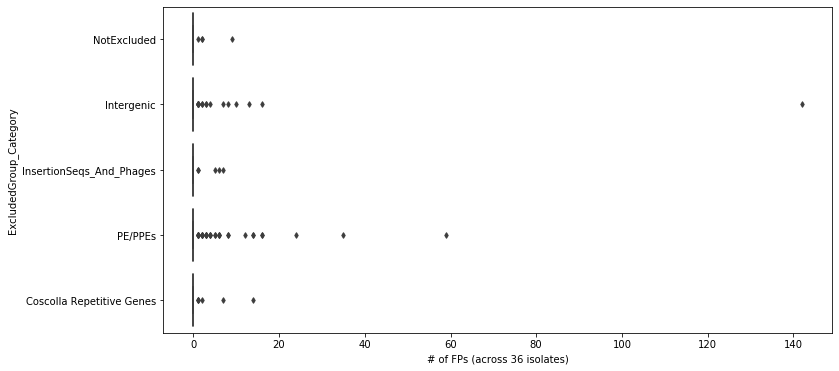

In [49]:
fig, axs = plt.subplots(1, 1, figsize=(12, 6) ) #, sharex=True)

sns.boxplot(y = "ExcludedGroup_Category", x = "FP_Count",
           data = AllRegions_AnnoByFPs_FiltMQ30_DF, 
            whis = 1.5,
            fliersize = 4, ax = axs)

#sns.stripplot(y="ExcludedGroup_Category", x="FP_Count", data=AllRegions_AnnoBy_FPs_SVs_DF, alpha = 0.7 , ax = axs, jitter=True)

#axs.set_yticklabels(GeneCat_Labels)

axs.set(xlabel='# of FPs (across 36 isolates)', ylabel='ExcludedGroup_Category')

plt.show()

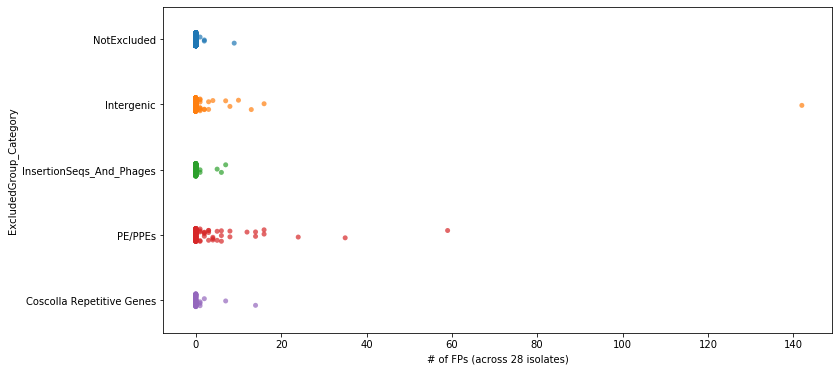

In [50]:
fig, axs = plt.subplots(1, 1, figsize=(12, 6) ) #, sharex=True)


sns.stripplot(y="ExcludedGroup_Category", x="FP_Count", data=AllRegions_AnnoByFPs_FiltMQ30_DF, alpha = 0.7 , ax = axs, jitter=True)     

#axs.set_yticklabels(GeneCat_Labels)

axs.set(xlabel='# of FPs (across 28 isolates)', ylabel='ExcludedGroup_Category')

plt.show()

In [51]:
AllRegions_AnnoByFPs_FiltMQ30_DF[ AllRegions_AnnoByFPs_FiltMQ30_DF["FP_Count"] >= 1 ].shape

(64, 11)

In [52]:
AllRegions_FiltMQ30_With_Atleast_1_FP = AllRegions_AnnoByFPs_FiltMQ30_DF[ AllRegions_AnnoByFPs_FiltMQ30_DF["FP_Count"] >= 1 ]
AllRegions_FiltMQ30_With_Atleast_1_FP["CenterOfRegion"] = ((AllRegions_AnnoByFPs_FiltMQ30_DF["Start"] + AllRegions_AnnoByFPs_FiltMQ30_DF["End"]) / 2)
AllRegions_FiltMQ30_With_Atleast_1_FP.shape

/home/mm774/conda3/envs/py37_S/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


(64, 12)

In [53]:
GLA_DF_WiFPs_FiltMQ30_With_Atleast_1_FP = GLA_DF_WiFPs[ GLA_DF_WiFPs["FP_Count"] >= 1 ]
GLA_DF_WiFPs_FiltMQ30_With_Atleast_1_FP["CenterOfRegion"] = ((GLA_DF_WiFPs_FiltMQ30_With_Atleast_1_FP["Start"] + GLA_DF_WiFPs_FiltMQ30_With_Atleast_1_FP["End"]) / 2)
GLA_DF_WiFPs_FiltMQ30_With_Atleast_1_FP.shape

/home/mm774/conda3/envs/py37_S/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


(46, 25)

In [54]:
GLA_DF_WiFPs

,Chrom_x,Start,End,Strand_x,H37rv_GeneID,Symbol,Feature,ExcludedGroup_Category,PEandPPE_Subfamily,Product,Functional_Category,Is_Pseudogene,Mean_EBR_36CI,gene_PercentPerfect_EBR_36CI,gene_ProportionWith_NANs_EBR_36CI,gene_GC_Content,Mean_PileupMapScore_K50_E4,Mean_PileupMapScore_K100_E4,Mean_PileupMapScore_K125_E4,Length_x,Chrom_y,Strand_y,FP_Count,Length_y
0,NC_000962.3,0,1524,+,Rv0001,dnaA,CDS,NotExcluded,None,Chromosomal replication initiator protein DnaA,information pathways,No,0.997430,92.979003,0.0,58.923885,1.0,1.0,1.0,1524,NC_000962.3,+,0,1524
1,NC_000962.3,2051,3260,+,Rv0002,dnaN,CDS,NotExcluded,None,DNA polymerase III (beta chain) DnaN (DNA nucl...,information pathways,No,0.998093,93.134822,0.0,59.966915,1.0,1.0,1.0,1209,NC_000962.3,+,0,1209
2,NC_000962.3,3279,4437,+,Rv0003,recF,CDS,NotExcluded,None,DNA replication and repair protein RecF (singl...,information pathways,No,1.000000,100.000000,0.0,59.930915,1.0,1.0,1.0,1158,NC_000962.3,+,0,1158
3,NC_000962.3,4433,4997,+,Rv0004,Rv0004,CDS,NotExcluded,None,Conserved hypothetical protein,conserved hypotheticals,No,1.000000,100.000000,0.0,66.134752,1.0,1.0,1.0,564,NC_000962.3,+,0,564
4,NC_000962.3,5239,7267,+,Rv0005,gyrB,CDS,NotExcluded,None,DNA gyrase (subunit B) GyrB (DNA topoisomerase...,information pathways,No,1.000000,100.000000,0.0,60.207101,1.0,1.0,1.0,2028,NC_000962.3,+,0,2028
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4074,NC_000962.3,4408333,4408897,-,Rv3920c,Rv3920c,CDS,NotExcluded,None,Conserved protein similar to jag protein,conserved hypotheticals,No,1.000000,100.000000,0.0,64.184397,1.0,1.0,1.0,564,NC_000962.3,-,0,564
4075,NC_000962.3,4408968,4410069,-,Rv3921c,Rv3921c,CDS,NotExcluded,None,Probable conserved transmembrane protein,cell wall and cell processes,No,1.000000,100.000000,0.0,60.036331,1.0,1.0,1.0,1101,NC_000962.3,-,0,1101
4076,NC_000962.3,4410052,4410415,-,Rv3922c,Rv3922c,CDS,NotExcluded,None,Possible hemolysin,"virulence, detoxification, adaptation",No,1.000000,100.000000,0.0,60.055096,1.0,1.0,1.0,363,NC_000962.3,-,0,363
4077,NC_000962.3,4410411,4410789,-,Rv3923c,rnpA,CDS,NotExcluded,None,Ribonuclease P protein component RnpA (RNaseP ...,information pathways,No,1.000000,100.000000,0.0,62.962963,1.0,1.0,1.0,378,NC_000962.3,-,0,378


In [55]:
AllRegions_FiltMQ30_With_Atleast_1_FP.head(3)

,Chrom,Start,End,Strand,H37rv_GeneID,Symbol,ExcludedGroup_Category,PEandPPE_Subfamily,Functional_Category,FP_Count,Length,CenterOfRegion
499,NC_000962.3,154129,154231,NaN,IntergenicRegion_106_Rv0126-Rv0127,NaN,Intergenic,NaN,Intergenic,1,102,154180.0
767,NC_000962.3,333436,336310,-,Rv0278c,PE_PGRS3,PE/PPEs,PE_V_PGRS,PE/PPE,4,2874,334873.0
769,NC_000962.3,336559,339073,-,Rv0279c,PE_PGRS4,PE/PPEs,PE_V_PGRS,PE/PPE,4,2514,337816.0


In [56]:
AllRegions_FiltMQ30_With_Atleast_1_FP["ExcludedGroup_Category"].value_counts()

PE/PPEs                      31
Intergenic                   18
Coscolla Repetitive Genes     6
InsertionSeqs_And_Phages      5
NotExcluded                   4
Name: ExcludedGroup_Category, dtype: int64

In [57]:
AllRegions_FiltMQ30_With_Atleast_1_FP.groupby("ExcludedGroup_Category")["FP_Count"].sum()

ExcludedGroup_Category
Coscolla Repetitive Genes     26
InsertionSeqs_And_Phages      20
Intergenic                   217
NotExcluded                   14
PE/PPEs                      271
Name: FP_Count, dtype: int64

In [58]:
AllRegions_FiltMQ30_With_Atleast_1_FP.groupby("ExcludedGroup_Category")["FP_Count"].sum().sum()

548

In [59]:
GLA_DF_WiFPs.head()

,Chrom_x,Start,End,Strand_x,H37rv_GeneID,Symbol,Feature,ExcludedGroup_Category,PEandPPE_Subfamily,Product,Functional_Category,Is_Pseudogene,Mean_EBR_36CI,gene_PercentPerfect_EBR_36CI,gene_ProportionWith_NANs_EBR_36CI,gene_GC_Content,Mean_PileupMapScore_K50_E4,Mean_PileupMapScore_K100_E4,Mean_PileupMapScore_K125_E4,Length_x,Chrom_y,Strand_y,FP_Count,Length_y
0,NC_000962.3,0,1524,+,Rv0001,dnaA,CDS,NotExcluded,None,Chromosomal replication initiator protein DnaA,information pathways,No,0.997430,92.979003,0.0,58.923885,1.0,1.0,1.0,1524,NC_000962.3,+,0,1524
1,NC_000962.3,2051,3260,+,Rv0002,dnaN,CDS,NotExcluded,None,DNA polymerase III (beta chain) DnaN (DNA nucl...,information pathways,No,0.998093,93.134822,0.0,59.966915,1.0,1.0,1.0,1209,NC_000962.3,+,0,1209
2,NC_000962.3,3279,4437,+,Rv0003,recF,CDS,NotExcluded,None,DNA replication and repair protein RecF (singl...,information pathways,No,1.000000,100.000000,0.0,59.930915,1.0,1.0,1.0,1158,NC_000962.3,+,0,1158
3,NC_000962.3,4433,4997,+,Rv0004,Rv0004,CDS,NotExcluded,None,Conserved hypothetical protein,conserved hypotheticals,No,1.000000,100.000000,0.0,66.134752,1.0,1.0,1.0,564,NC_000962.3,+,0,564
4,NC_000962.3,5239,7267,+,Rv0005,gyrB,CDS,NotExcluded,None,DNA gyrase (subunit B) GyrB (DNA topoisomerase...,information pathways,No,1.000000,100.000000,0.0,60.207101,1.0,1.0,1.0,2028,NC_000962.3,+,0,2028


In [60]:
GLA_DF_WiFPs["CenterOfRegion"] = ((GLA_DF_WiFPs["Start"] + GLA_DF_WiFPs["End"]) / 2)
AllRegions_FiltMQ30_With_Atleast_1_FP["CenterOfRegion"] = ((AllRegions_FiltMQ30_With_Atleast_1_FP["Start"] + AllRegions_FiltMQ30_With_Atleast_1_FP["End"]) / 2)

/home/mm774/conda3/envs/py37_S/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [61]:
GLA_DF_WiFPs.shape

(4079, 25)

# Plot distribution of FPs (All Regions w/ atleast 1 FP)

In [62]:
AllRegions_FiltMQ30_With_Atleast_1_FP["ExcludedGroup_Category"].value_counts()

PE/PPEs                      31
Intergenic                   18
Coscolla Repetitive Genes     6
InsertionSeqs_And_Phages      5
NotExcluded                   4
Name: ExcludedGroup_Category, dtype: int64

In [63]:

dictOf_GeneGroupToColor = {"Intergenic" : "#4FC1E8" ,
                           "PE/PPEs" : "#FFCE54" ,
                           "Coscolla Repetitive Genes" : "#A0D568" ,
                           "NotExcluded" : "#ED5564",
                           "InsertionSeqs_And_Phages" : "#AC92EB" , }


mkdir: cannot create directory ‘./H37rv_FP_Distr_plots_PBMM2_GT/’: File exists


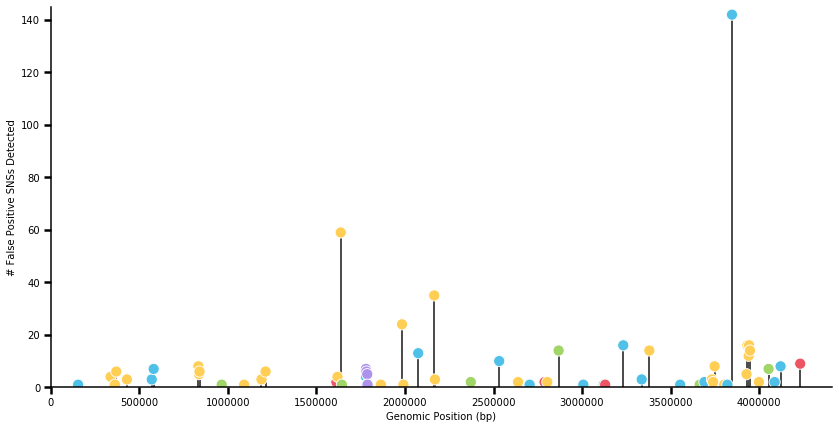

In [72]:
fig, axes = plt.subplots(1, 1, figsize=(14, 7) ) #, sharex=True)

for x,y in zip(list(AllRegions_FiltMQ30_With_Atleast_1_FP["CenterOfRegion"].values), list(AllRegions_FiltMQ30_With_Atleast_1_FP["FP_Count"].values)):
    axes.fill_between([x], [y], color='#4D4D4D', alpha = 1, linewidth = 2)
    
sns.scatterplot(x = "CenterOfRegion", y = "FP_Count", hue = "ExcludedGroup_Category",
                legend = False, data = AllRegions_FiltMQ30_With_Atleast_1_FP, ax = axes, s = 125, palette = dictOf_GeneGroupToColor)
    


axes.spines["left"].set_linewidth(1.5)
axes.spines["bottom"].set_linewidth(1.5)

sns.despine(ax=axes)

axes.tick_params(width=2.5, length=7)

axes.set_ylim(0, 145)
axes.set_xlim(0, 4411532)
#axes.set_xlim(0, 500000)

plt.ylabel("# False Positive SNSs Detected")
plt.xlabel("Genomic Position (bp)")

!mkdir ./H37rv_FP_Distr_plots_PBMM2_GT/

Output_PDF_PATH = "./H37rv_FP_Distr_plots_PBMM2_GT/Fig7_H37rv_36CI_FP_Distr_plot_RegionLevel_V2.pdf"
#Output_SVG_PATH = "./H37rv_FP_Distr_plots_PBMM2_GT/Fig7_H37rv_36CI_FP_Distr_plot_RegionLevel_V2.svg"
#Output_PNG_PATH = "./H37rv_FP_Distr_plots_PBMM2_GT/Fig7_H37rv_36CI_FP_Distr_plot_RegionLevel_V2.png"
#plt.savefig(Output_PNG_PATH, bbox_inches='tight', dpi=300)
#plt.savefig(Output_SVG_PATH, bbox_inches='tight')
plt.savefig(Output_PDF_PATH, bbox_inches='tight')

plt.show()

mkdir: cannot create directory ‘./H37rv_FP_Distr_plots_PBMM2_GT/’: File exists


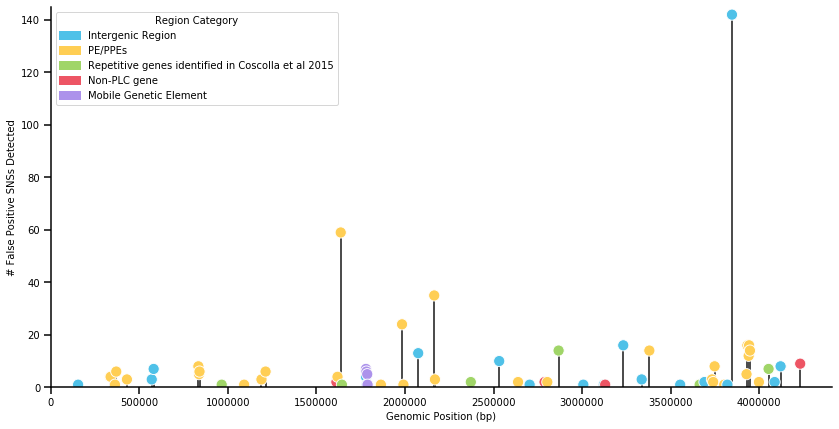

In [71]:
fig, axes = plt.subplots(1, 1, figsize=(14, 7) ) #, sharex=True)

for x,y in zip(list(AllRegions_FiltMQ30_With_Atleast_1_FP["CenterOfRegion"].values), list(AllRegions_FiltMQ30_With_Atleast_1_FP["FP_Count"].values)):
    axes.fill_between([x], [y], color='#4D4D4D', alpha = 1, linewidth = 2)
    
sns.scatterplot(x = "CenterOfRegion", y = "FP_Count", hue = "ExcludedGroup_Category",
                legend = False, data = AllRegions_FiltMQ30_With_Atleast_1_FP, ax = axes, s = 125, palette = dictOf_GeneGroupToColor)


axes.spines["left"].set_linewidth(1.5)
axes.spines["bottom"].set_linewidth(1.5)

sns.despine(ax=axes)

axes.tick_params(width=1.5, length=7)

axes.set_ylim(0, 145)
axes.set_xlim(0, 4411532)
#axes.set_xlim(0, 500000)


plt.legend(title='Region Category', loc='upper left', labels=['Intergenic Region',
                                                              "PE/PPEs",
                                                              'Repetitive genes identified in Coscolla et al 2015',
                                                              'Non-PLC gene',
                                                              "Mobile Genetic Element"])

leg = axes.get_legend()
leg.legendHandles[0].set_color('#4FC1E8')
leg.legendHandles[1].set_color('#FFCE54')
leg.legendHandles[2].set_color('#A0D568')
leg.legendHandles[3].set_color('#ED5564')
leg.legendHandles[4].set_color('#AC92EB')

plt.ylabel("# False Positive SNSs Detected")
plt.xlabel("Genomic Position (bp)")

!mkdir ./H37rv_FP_Distr_plots_PBMM2_GT/

Output_PDF_PATH = "./H37rv_FP_Distr_plots_PBMM2_GT/Fig7_H37rv_36CI_FP_Distr_plot_RegionLevel_V2.WiLegend.pdf"
Output_SVG_PATH = "./H37rv_FP_Distr_plots_PBMM2_GT/Fig7_H37rv_36CI_FP_Distr_plot_RegionLevel_V2.WiLegend.svg"
Output_PNG_PATH = "./H37rv_FP_Distr_plots_PBMM2_GT/Fig7_H37rv_36CI_FP_Distr_plot_RegionLevel_V2.WiLegend.png"
plt.savefig(Output_PNG_PATH, bbox_inches='tight', dpi=300)
#plt.savefig(Output_SVG_PATH, bbox_inches='tight')
#plt.savefig(Output_PDF_PATH, bbox_inches='tight')

plt.show()

In [66]:
AllRegions_FiltMQ30_With_Atleast_1_FP.groupby("ExcludedGroup_Category")["FP_Count"].sum()

ExcludedGroup_Category
Coscolla Repetitive Genes     26
InsertionSeqs_And_Phages      20
Intergenic                   217
NotExcluded                   14
PE/PPEs                      271
Name: FP_Count, dtype: int64

In [67]:
AllRegions_FiltMQ30_With_Atleast_1_FP.groupby("ExcludedGroup_Category")["FP_Count"].sum().sum()

548

In [68]:
AllRegions_FiltMQ30_With_Atleast_1_FP[AllRegions_FiltMQ30_With_Atleast_1_FP["ExcludedGroup_Category"] == "NotExcluded"]

,Chrom,Start,End,Strand,H37rv_GeneID,Symbol,ExcludedGroup_Category,PEandPPE_Subfamily,Functional_Category,FP_Count,Length,CenterOfRegion
2810,NC_000962.3,1612341,1612950,-,Rv1435c,Rv1435c,NotExcluded,None,cell wall and cell processes,2,609,1612645.5
4633,NC_000962.3,2786913,2789283,-,Rv2482c,plsB2,NotExcluded,None,lipid metabolism,2,2370,2788098.0
202,NC_000962.3,3129343,3131773,-,Rv2823c,Rv2823c,NotExcluded,None,conserved hypotheticals,1,2430,3130558.0
6917,NC_000962.3,4231319,4232393,+,Rv3785,Rv3785,NotExcluded,None,conserved hypotheticals,9,1074,4231856.0


In [69]:
AllRegions_FiltMQ30_With_Atleast_1_FP.head()

,Chrom,Start,End,Strand,H37rv_GeneID,Symbol,ExcludedGroup_Category,PEandPPE_Subfamily,Functional_Category,FP_Count,Length,CenterOfRegion
499,NC_000962.3,154129,154231,NaN,IntergenicRegion_106_Rv0126-Rv0127,NaN,Intergenic,NaN,Intergenic,1,102,154180.0
767,NC_000962.3,333436,336310,-,Rv0278c,PE_PGRS3,PE/PPEs,PE_V_PGRS,PE/PPE,4,2874,334873.0
769,NC_000962.3,336559,339073,-,Rv0279c,PE_PGRS4,PE/PPEs,PE_V_PGRS,PE/PPE,4,2514,337816.0
796,NC_000962.3,361333,363109,+,Rv0297,PE_PGRS5,PE/PPEs,PE_V_PGRS,PE/PPE,1,1776,362221.0
807,NC_000962.3,366149,372764,-,Rv0304c,PPE5,PE/PPEs,None,PE/PPE,6,6615,369456.5


In [70]:
AllRegions_FiltMQ30_With_Atleast_1_FP[AllRegions_FiltMQ30_With_Atleast_1_FP["ExcludedGroup_Category"] == "NotExcluded"]

,Chrom,Start,End,Strand,H37rv_GeneID,Symbol,ExcludedGroup_Category,PEandPPE_Subfamily,Functional_Category,FP_Count,Length,CenterOfRegion
2810,NC_000962.3,1612341,1612950,-,Rv1435c,Rv1435c,NotExcluded,None,cell wall and cell processes,2,609,1612645.5
4633,NC_000962.3,2786913,2789283,-,Rv2482c,plsB2,NotExcluded,None,lipid metabolism,2,2370,2788098.0
202,NC_000962.3,3129343,3131773,-,Rv2823c,Rv2823c,NotExcluded,None,conserved hypotheticals,1,2430,3130558.0
6917,NC_000962.3,4231319,4232393,+,Rv3785,Rv3785,NotExcluded,None,conserved hypotheticals,9,1074,4231856.0


In [71]:
#GLA_DF_WiFPs_FiltMQ30_With_Atleast_1_FP[GLA_DF_WiFPs_FiltMQ30_With_Atleast_1_FP["ExcludedGroup_Category"] == "NotExcluded"]

In [72]:
AllRegions_FiltMQ30_With_Atleast_1_FP[AllRegions_FiltMQ30_With_Atleast_1_FP["ExcludedGroup_Category"] == "NotExcluded"]["Symbol"].values

array(['Rv1435c', 'plsB2', 'Rv2823c', 'Rv3785'], dtype=object)

In [73]:
### Rv3785, Rv2823c, plsB2, Rv1435c

In [74]:
### Rv3785 (9 FP), Rv2823c (1 FP), plsB2 (2 FP), Rv1435c (2 FP)

In [75]:
GLA_DF_WiFPs_Top30SourcesOfFPs_DF = GLA_DF_WiFPs.sort_values("FP_Count", ascending=False).head(30)
GLA_DF_WiFPs_Top30SourcesOfFPs_DF.shape

(30, 25)

In [76]:
GLA_DF_WiFPs_Top30SourcesOfFPs_DF

,Chrom_x,Start,End,Strand_x,H37rv_GeneID,Symbol,Feature,ExcludedGroup_Category,PEandPPE_Subfamily,Product,Functional_Category,Is_Pseudogene,Mean_EBR_36CI,gene_PercentPerfect_EBR_36CI,gene_ProportionWith_NANs_EBR_36CI,gene_GC_Content,Mean_PileupMapScore_K50_E4,Mean_PileupMapScore_K100_E4,Mean_PileupMapScore_K125_E4,Length_x,Chrom_y,Strand_y,FP_Count,Length_y,CenterOfRegion
1510,NC_000962.3,1636003,1638229,-,Rv1452c,PE_PGRS28,CDS,PE/PPEs,PE_V_PGRS,PE-PGRS family protein PE_PGRS28,PE/PPE,No,0.619514,10.197664,0.057053,77.268643,0.768104,0.792689,0.798796,2226,NC_000962.3,-,59,2226,1637116.0
1985,NC_000962.3,2162931,2167311,-,Rv1917c,PPE34,CDS,PE/PPEs,PPE_SL-5_PPE-MPTR,PPE family protein PPE34,PE/PPE,No,0.884756,10.662100,0.000000,59.748858,0.885986,0.933980,0.945244,4380,NC_000962.3,-,35,4380,2165121.0
1820,NC_000962.3,1981613,1984775,-,Rv1753c,PPE24,CDS,PE/PPEs,PPE_SL-5_PPE-MPTR,PPE family protein PPE24,PE/PPE,No,0.942731,75.901328,0.000000,61.574953,0.863567,0.899072,0.916509,3162,NC_000962.3,-,24,3162,1983194.0
3652,NC_000962.3,3941723,3944963,+,Rv3512,PE_PGRS56,CDS,PE/PPEs,PE_V_PGRS,PE-PGRS family protein PE_PGRS56,PE/PPE,No,0.806225,0.000000,0.000000,80.185185,0.951888,0.983721,0.991760,3240,NC_000962.3,+,16,3240,3943343.0
3648,NC_000962.3,3931004,3936710,+,Rv3508,PE_PGRS54,CDS,PE/PPEs,PE_V_PGRS,PE-PGRS family protein PE_PGRS54,PE/PPE,No,0.533376,2.225727,0.036979,80.529267,0.583865,0.662627,0.680470,5706,NC_000962.3,+,16,5706,3933857.0
3654,NC_000962.3,3945793,3950263,+,Rv3514,PE_PGRS57,CDS,PE/PPEs,PE_V_PGRS,PE-PGRS family protein PE_PGRS57,PE/PPE,No,0.498909,4.362416,0.039597,80.581655,0.449548,0.569545,0.612959,4470,NC_000962.3,+,14,4470,3948028.0
2649,NC_000962.3,2867123,2867786,+,Rv2544,lppB,CDS,Coscolla Repetitive Genes,None,Probable conserved lipoprotein LppB,cell wall and cell processes,No,0.989005,35.897436,0.417798,59.426848,0.718748,0.948741,0.998492,663,NC_000962.3,+,14,663,2867454.5
3144,NC_000962.3,3379375,3380452,-,Rv3021c,PPE47,CDS,PE/PPEs,None,PPE family protein PPE47,PE/PPE,Yes,0.845063,0.000000,0.000000,62.859796,0.660229,0.717270,0.740483,1077,NC_000962.3,-,14,1077,3379913.5
3651,NC_000962.3,3939616,3941761,+,Rv3511,PE_PGRS55,CDS,PE/PPEs,PE_V_PGRS,PE-PGRS family protein PE_PGRS55,PE/PPE,No,0.881381,22.377622,0.000000,76.923077,0.883061,0.936688,0.960867,2145,NC_000962.3,+,12,2145,3940688.5
3939,NC_000962.3,4231319,4232393,+,Rv3785,Rv3785,CDS,NotExcluded,None,Hypothetical protein,conserved hypotheticals,No,0.993482,97.392924,0.000000,67.597765,1.000000,1.000000,1.000000,1074,NC_000962.3,+,9,1074,4231856.0


# How many non-PLC genes had at least 1 FP?

In [77]:
AllRegions_FiltMQ30_With_Atleast_1_FP["ExcludedGroup_Category"].value_counts()

PE/PPEs                      31
Intergenic                   18
Coscolla Repetitive Genes     6
InsertionSeqs_And_Phages      5
NotExcluded                   4
Name: ExcludedGroup_Category, dtype: int64

In [80]:
AllRegions_FiltMQ30_With_Atleast_1_FP[ AllRegions_FiltMQ30_With_Atleast_1_FP["ExcludedGroup_Category"] == "NotExcluded"]   

,Chrom,Start,End,Strand,H37rv_GeneID,Symbol,ExcludedGroup_Category,PEandPPE_Subfamily,Functional_Category,FP_Count,Length,CenterOfRegion
2810,NC_000962.3,1612341,1612950,-,Rv1435c,Rv1435c,NotExcluded,None,cell wall and cell processes,2,609,1612645.5
4633,NC_000962.3,2786913,2789283,-,Rv2482c,plsB2,NotExcluded,None,lipid metabolism,2,2370,2788098.0
202,NC_000962.3,3129343,3131773,-,Rv2823c,Rv2823c,NotExcluded,None,conserved hypotheticals,1,2430,3130558.0
6917,NC_000962.3,4231319,4232393,+,Rv3785,Rv3785,NotExcluded,None,conserved hypotheticals,9,1074,4231856.0


# How many PE/PPE genes ever had a single false positive?

In [ ]:
AllRegions_FiltMQ30_With_Atleast_1_FP.shape

In [ ]:
AllRegions_FiltMQ30_With_Atleast_1_FP["ExcludedGroup_Category"].value_counts()

In [ ]:
31/168

In [ ]:
AllRegions_FiltMQ30_With_Atleast_1_FP["PEandPPE_Subfamily"].value_counts()

In [ ]:
28 

In [ ]:
AllRegions_FiltMQ30_With_Atleast_1_FP.head()

# How many PE/PPE genes never had a single false positive?